# 목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를  생성하여 회귀분석을 실시하고 결과를 해석하라.(BMI 계산 시, WEIGHT는 파운드(1lb0.45kg), HEIGHT는 인치(1inch2.54cm)이므로 변환하여 사용)
# 데이터 : 체질검사.CSV(변수: 14, 자료 수: 252개)

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [81]:
df_raw=pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/체질검사.csv", engine="python")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [82]:
# 1. WEIGHT, HEIGHT 단위 변환

df_raw_converted = df_raw
df_raw_converted["WEIGHT"] = df_raw["WEIGHT"]*0.45
df_raw_converted["HEIGHT"] = df_raw["HEIGHT"]*2.54
df_raw_converted.rename(columns={'WEIGHT': 'WEIGHT_kg', 'HEIGHT': 'HEIGHT_cm'}, inplace=True)
df_raw_converted.head()

####열 이름 바꾸기

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [83]:
# 2. BMI 계산해서 새로운 열 삽입

'''
BMI = WEIGHT / HEIGHT*HEIGHT

고도 비만 : 40 이상
중등도 비만 (2단계 비만) : 35 - 39.9
경도 비만 (1단계 비만) : 30 - 34.9
과체중 : 25 - 29.9
정상 : 18.5 - 24.9
저체중 : 18.5 미만
'''
df_raw_converted["BMI"] = df_raw_converted["WEIGHT_kg"] * 10000 / (df_raw_converted["HEIGHT_cm"]*df_raw_converted["HEIGHT_cm"])
df_raw_converted.head()


,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


 2018년 비만진료지침에서 단계별 용어가 새롭게 변경되어 18.5 미만이면 저체중, 18.5∼23은 정상, 23~25이면 '비만 전단계'[5], 25∼30은 '1단계 비만', 30∼35는 '2단계 비만' , 35 이상이면 '3단계 비만'으로 구분한다.

복부비만을 측정하는 신체계측지표로 허리둘레(Waist
circumference; WC), 허리/엉덩이 둘레비(Waist-to-hip ratio; WHR), 허리/신장비(Waist-to-height
ratio; WHtR)

In [84]:
df_raw_converted["WHR"] = df_raw_converted["ABDOMEN"] / df_raw_converted["HIP"]
df_raw_converted["WHtR"] = df_raw_converted["ABDOMEN"] / df_raw_converted["HEIGHT_cm"]
df_raw_converted.head()

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI,WHR,WHtR
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870,1.002708,0.807018
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595,0.837037,0.437077
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478,0.966429,0.546008
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617,0.958935,0.517350
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165,1.082447,0.751107


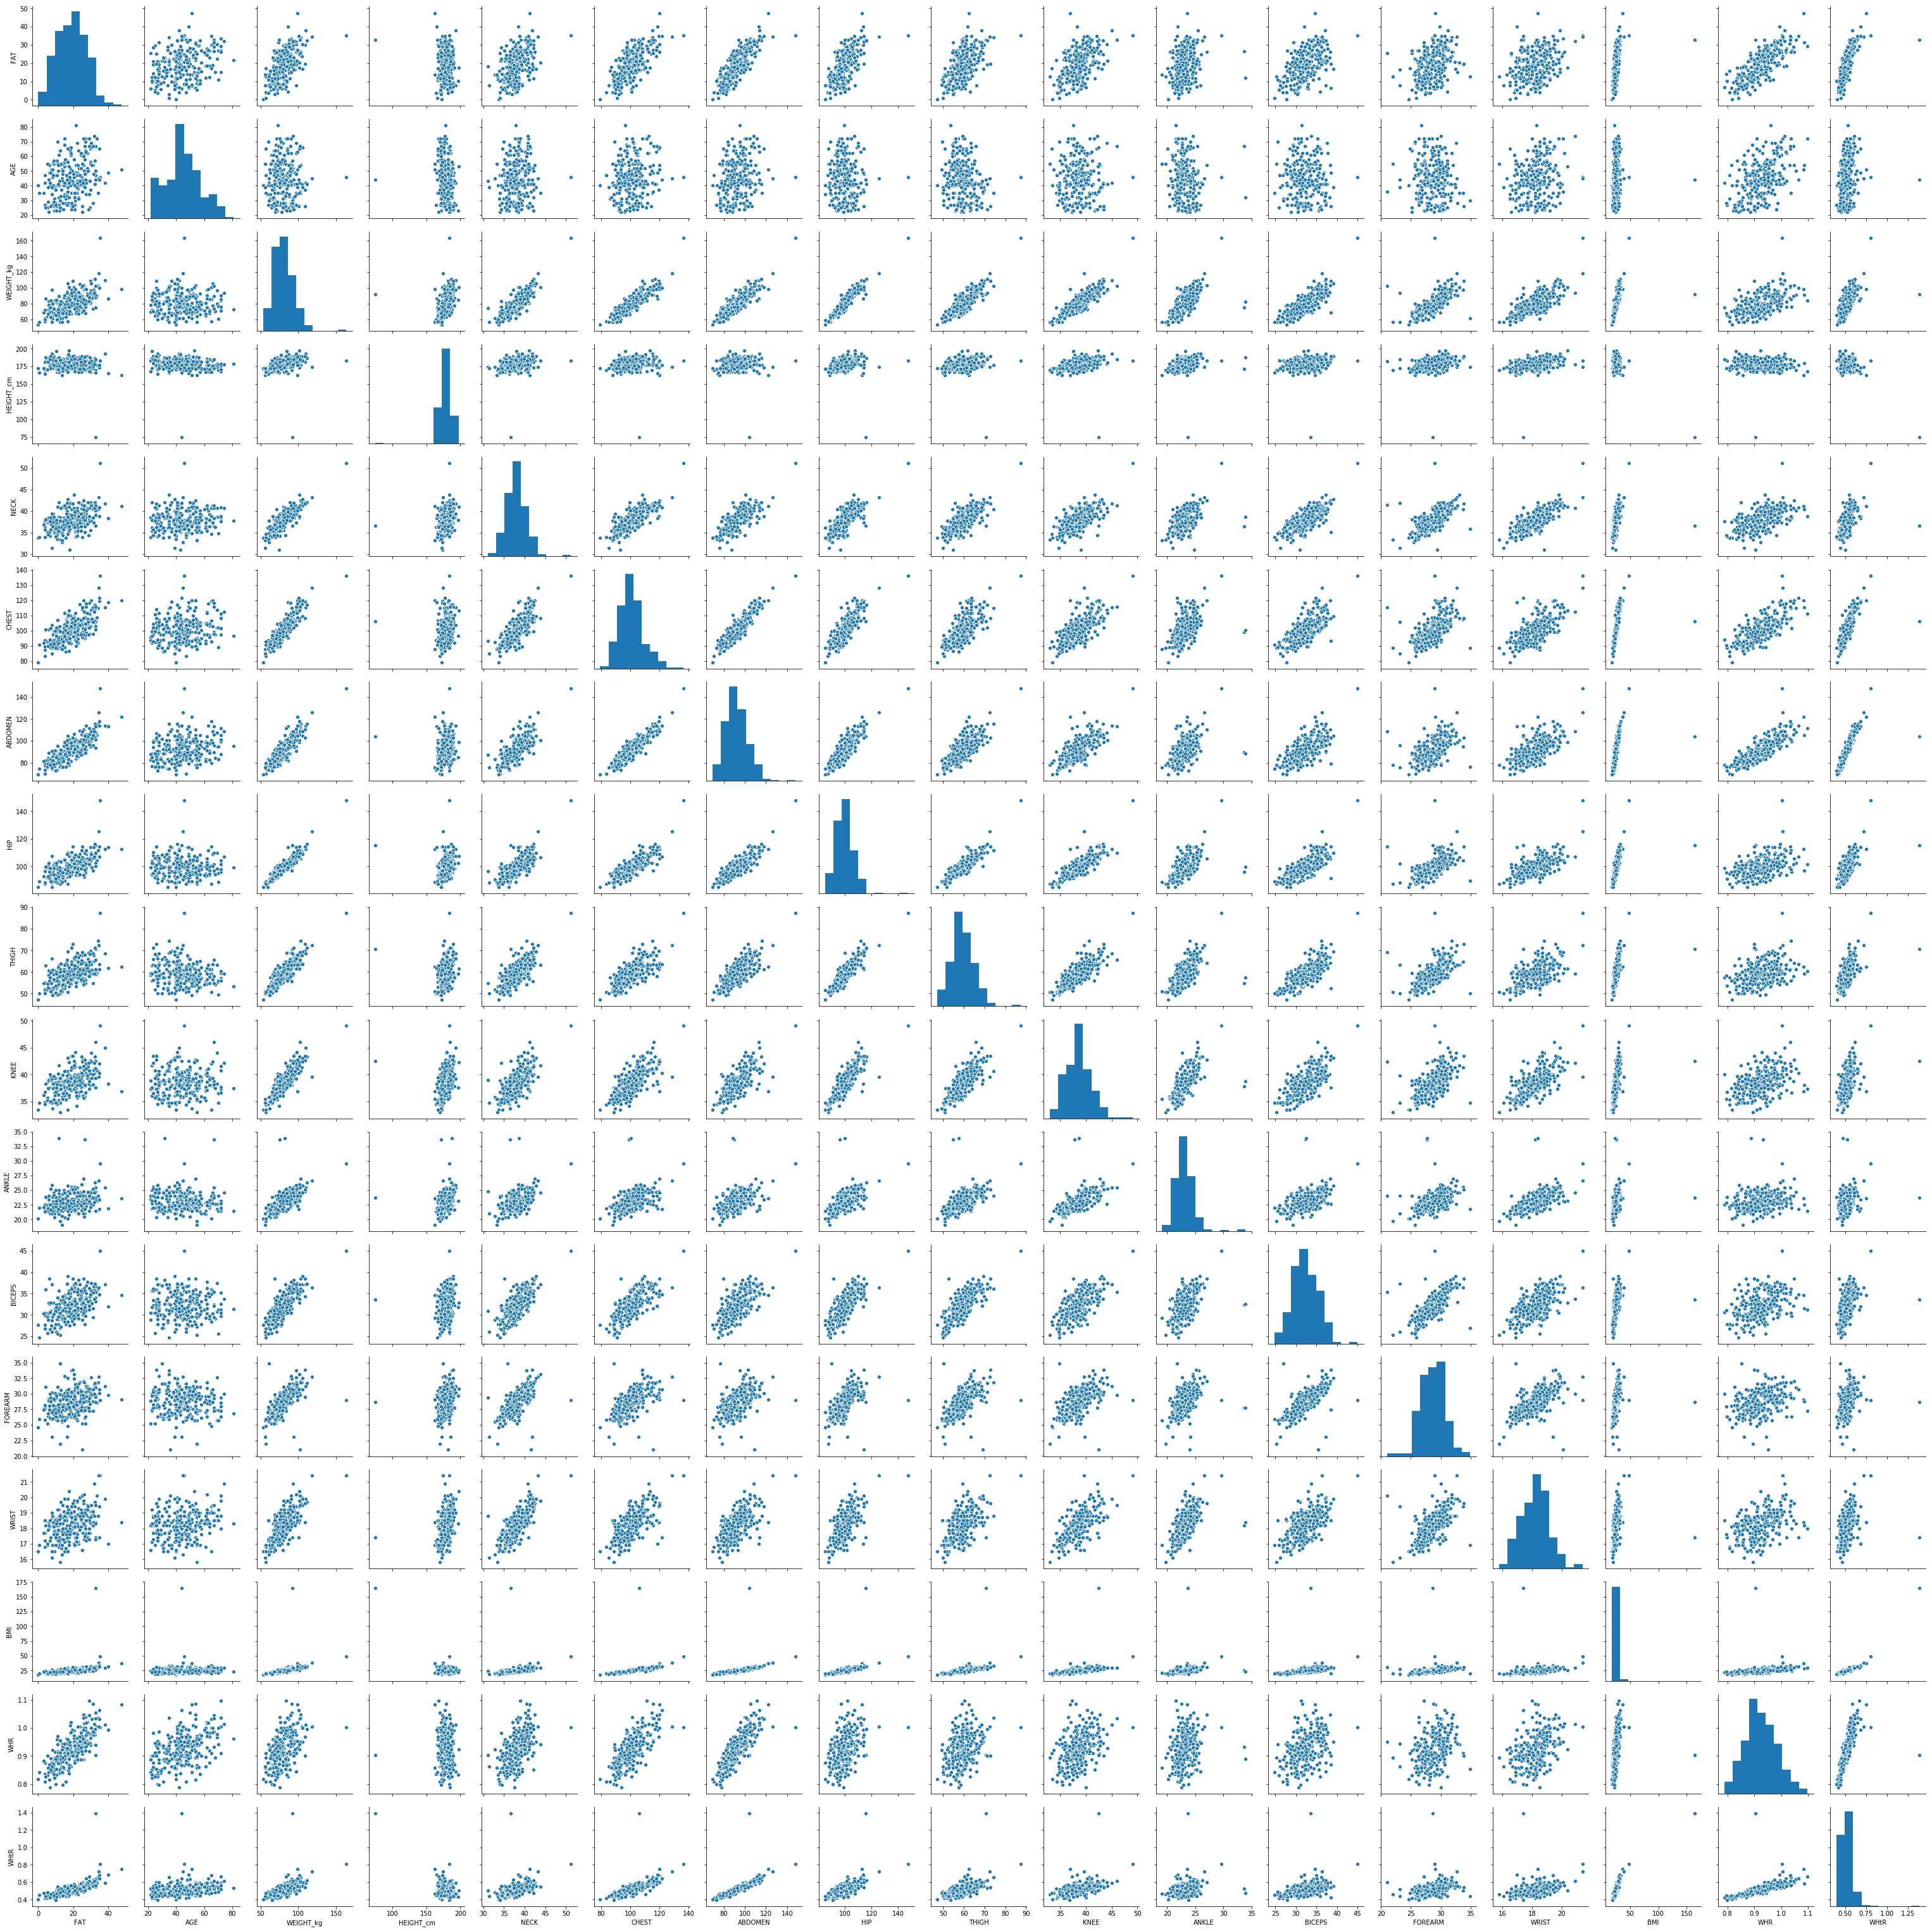

In [85]:
sns.pairplot(df_raw_converted)

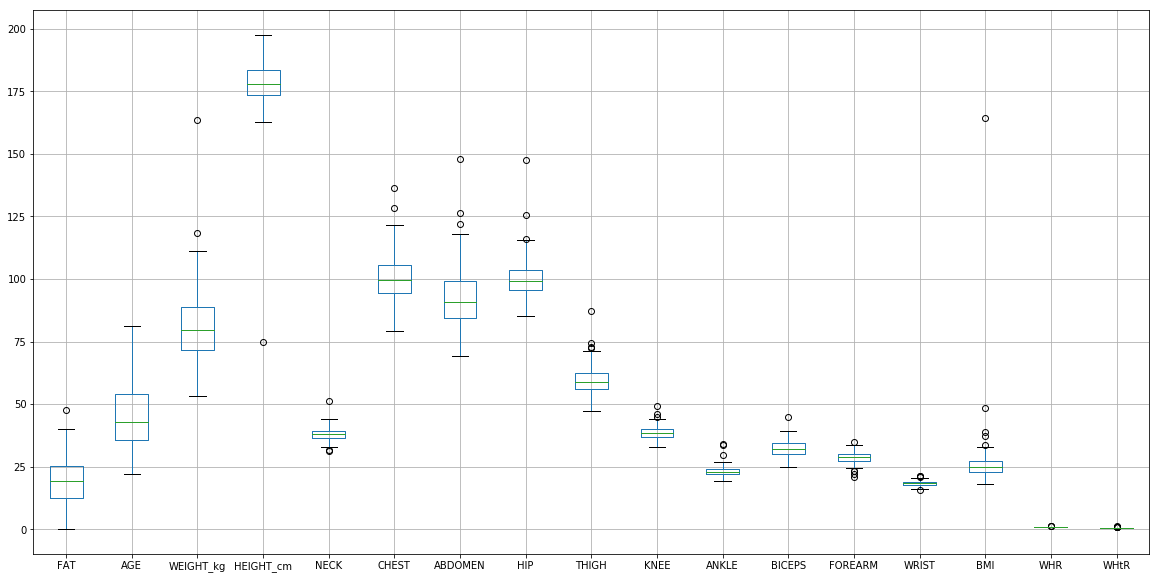

In [86]:
df_raw_converted.boxplot(figsize=(20,10))

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


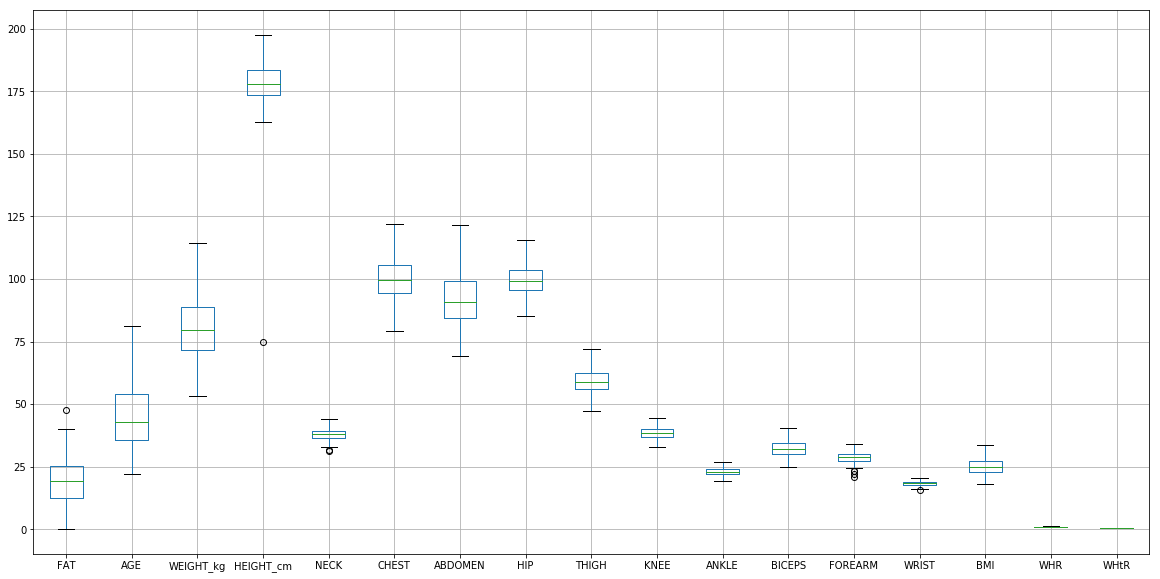

In [89]:
for x in df_raw_converted.columns:
   if x != 'FAT' and x != 'AGE':
       a = np.percentile(df_raw_converted[x],[25,75])
       l = a[1] + 1.5*(a[1]-a[0])
       df_raw_converted[x][df_raw_converted[x]>l] = l 
        
df_raw_converted.boxplot(figsize=(20,10))

In [91]:
df_raw_converted.describe().round(3)

,FAT,AGE,WEIGHT_kg,HEIGHT_cm,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI,WHR,WHtR
count,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000,252.000
mean,19.151,44.885,80.305,178.178,37.963,100.742,92.429,99.735,59.328,38.562,23.038,32.256,28.661,18.222,25.122,0.924,0.518
std,8.369,12.602,12.284,9.304,2.314,8.162,10.294,6.438,4.963,2.322,1.404,2.959,2.011,0.911,3.275,0.059,0.057
min,0.000,22.000,53.325,74.930,31.100,79.300,69.400,85.000,47.200,33.000,19.100,24.800,21.000,15.800,17.875,0.788,0.397
25%,12.475,35.750,71.550,173.355,36.400,94.350,84.575,95.500,56.000,36.975,22.000,30.200,27.300,17.600,22.853,0.886,0.476
50%,19.200,43.000,79.425,177.800,38.000,99.650,90.950,99.300,59.000,38.500,22.800,32.050,28.700,18.300,24.896,0.920,0.514
75%,25.300,54.000,88.650,183.515,39.425,105.375,99.325,103.525,62.350,39.925,24.000,34.325,30.000,18.800,27.118,0.963,0.552
max,47.500,81.000,114.300,197.485,43.962,121.912,121.450,115.563,71.875,44.350,27.000,40.512,34.050,20.600,33.515,1.079,0.667


In [92]:
# VIP >10 인 변수를 순차적으로 제거함으로써 다중공선성 해결

df_raw_x = df_raw_converted.drop("FAT", axis=1)
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,AGE,2.322
12,FOREARM,2.437
10,ANKLE,2.842
11,BICEPS,3.561
13,WRIST,3.623
4,NECK,4.166
9,KNEE,5.127
3,HEIGHT_cm,5.266
8,THIGH,7.851
5,CHEST,11.226


In [93]:
df_raw_x_const = df_raw_x_const.drop("ABDOMEN", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
1,AGE,2.317
11,FOREARM,2.431
9,ANKLE,2.824
10,BICEPS,3.554
12,WRIST,3.621
3,HEIGHT_cm,4.000
4,NECK,4.162
8,KNEE,4.863
7,THIGH,7.620
5,CHEST,11.216


In [94]:
df_raw_x_const = df_raw_x_const.drop("WHtR", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
1,AGE,2.300
11,FOREARM,2.386
9,ANKLE,2.823
3,HEIGHT_cm,3.256
10,BICEPS,3.547
12,WRIST,3.615
14,WHR,3.968
4,NECK,4.157
8,KNEE,4.834
7,THIGH,7.524


In [95]:
df_raw_x_const = df_raw_x_const.drop("WEIGHT_kg", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
1,AGE,2.216
10,FOREARM,2.377
2,HEIGHT_cm,2.631
8,ANKLE,2.693
9,BICEPS,3.489
11,WRIST,3.550
13,WHR,3.884
3,NECK,3.967
7,KNEE,4.628
6,THIGH,7.511


In [96]:
df_raw_x_const = df_raw_x_const.drop("BMI", axis=1)
df_vif = pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace = True)
df_vif.round(3)

,variable,VIF
2,HEIGHT_cm,1.332
1,AGE,2.209
10,FOREARM,2.338
8,ANKLE,2.654
12,WHR,3.346
9,BICEPS,3.401
11,WRIST,3.541
3,NECK,3.872
7,KNEE,4.611
6,THIGH,7.163


In [97]:
# 
reg_model = smf.ols(formula = "FAT ~ HEIGHT_cm + AGE + NECK + CHEST + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI + WHR", data=df_raw_converted)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     57.07
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.67e-65
Time:                        22:35:26   Log-Likelihood:                -714.13
No. Observations:                 252   AIC:                             1456.
Df Residuals:                     238   BIC:                             1506.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -76.4079      9.277     -8.236      0.0

In [98]:
# 위의 결과에서 P-value > 0.05인 변수 제거
reg_model = smf.ols(formula = "FAT ~ AGE + NECK + HIP + WRIST + WHR", data=df_raw_converted)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     141.2
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           3.50e-70
Time:                        22:35:30   Log-Likelihood:                -721.95
No. Observations:                 252   AIC:                             1456.
Df Residuals:                     246   BIC:                             1477.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -89.0113      6.037    -14.745      0.0

In [99]:
# 위의 결과에서 P-value > 0.05인 변수 제거
reg_model = smf.ols(formula = "FAT ~ AGE + HIP + WRIST + WHR", data=df_raw_converted)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     174.5
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.00e-70
Time:                        22:35:33   Log-Likelihood:                -723.39
No. Observations:                 252   AIC:                             1457.
Df Residuals:                     247   BIC:                             1474.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -87.9083      6.023    -14.596      0.0

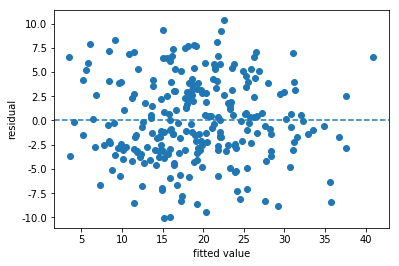

In [100]:
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("fitted value"); plt.ylabel("residual")
plt.axhline(y=0,linestyle="--")
mp.rcParams['axes.unicode_minus'] = False

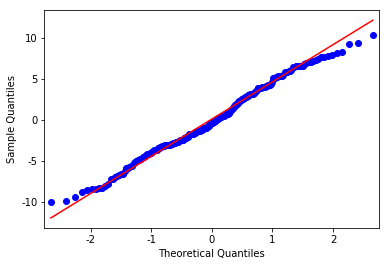

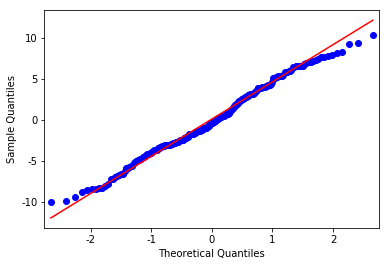

In [101]:
qqplot(reg_result.resid, line='q')